---
Following the Lynch et al paper https://iopscience.iop.org/article/10.3847/2041-8213/aacf9f

"We find that the gravitational-wave alert threshold change that would roughly double the number of detectable astrophysical events would increase the false-alarm rate by more than 5 orders of magnitude from 1 per 100 years to more than 1000 per year."

"We argue that EM follow-up thresholds for low-significance candidates should be set on the basis of alert purity (Pastro) and not false-alarm rate."

$FAR = FAR_8 \times [-\frac{\rho - 8}{\alpha}]$

* $FAR_8$ is the false alarm rate at a network ranking statistic $\rho = 8$
* $\alpha$ is a scale parameter that determines the steepness of the fall off

"For BBH we find α = 0.18 and FAR8 = 5500 yr−1"

---
From Nitz et al. 2017 https://doi.org/10.3847/1538-4357/aa8f50

The SNR and signal consistency tests (Allen paper) result in the detection statistic.

"We present a new detection statistic that reduces the false alarm rate of the search across the entire target signal space: binary neutron stars, binary black holes, and neutron star–black hole binaries. This detection statistic uses information from both the physical parameters of the gravitational-wave signal and the expected distribution of the noise background to rescale the “combined effective signal-to-noise ratio” used previously by the PyCBC search."

"The detection statistic used in Advanced LIGO’s first observing run was the quadrature sum of the re-weighted signal-to-noise ratio $\hat{\rho}$ observed in each detector, denoted $\hat{\rho_c}$"

$\hat{\rho} = \frac{\rho}{[1+(\chi^2)^3]^{1/6}}$

The $\chi^2$ here is to test the `signal' against the waveform. This test is less effective in the high mass end of CBCs since these signals are shorter and can more easily resemble a noice event.
* does that mean the relation between SNR and FAR has some spread that tracks the mass of the system?

"The non-stationarity of the detectors’ noise means that it is impossible to construct an analytic model of the search’s false alarm rate."

They look like they use PyCBC data to estimate the FAR for the run.

---

### Questions to look into
* How do I determine my own $\alpha$ ?
    * just fit the suggest model to the FAR/SNR
    * maybe a new model
* How does $\rho$ relate to the optimal SNR?
* How do you determine $FAR_8$?
    * same as above for $\alpha$

### To do:
* look for examples of FAR estimation for observing runs
    * probably linked in LIGO papers

The optimal matched filter signal-to-noise ratio squared:

$\rho^{2}_{opt} = <\mu , \mu>$

The SNR that bilby outputs is the matched filter SNR.
The comparisons done in the Lynch and Nitz papers use the ranking statictic $\hat{\rho}$.
* What is the SNR provided in the data release?
    * in the xml files they provide a $\chi^2$ value and an SNR for each event in the sngl_inspiral table so I can calculate the $\hat{\rho}$ if that is desired

"The snr column MUST report the absolute value of the complex matched filter SNR of the best-matching template. It MUST NOT report a modified SNR-like quantity such as newSNR." from https://lscsoft.docs.ligo.org/ligo.skymap/interface.html 
* so these are the complex-matched filter snrs
* therefore I am being consistent, the snrs from bilby are the same as those from the data release. I can therefore produce some kind of approximate relationship to take SNR to FAR, fitted to the data release info and apply this to my sampled SNRs.

In [2]:
import pandas as pd
import numpy as np
samples = pd.read_csv('params_inc_SNR.csv', index_col=0)
samples['net_snr'] = np.sqrt(samples['H1_snr']**2 + samples['L1_snr']**2 +samples['V1_snr']**2)

In [3]:
# ranking statistic function
def rho(SNR, chi):
    rho_hat = SNR/(1+(chi**2)**3)**(1/6)
    return rho_hat

In [4]:
samples[['net_snr','H1_snr', 'L1_snr', 'V1_snr' ]]

,net_snr,H1_snr,L1_snr,V1_snr
0,4.715177,2.647601,3.696115,1.249735
1,0.762437,0.497399,0.437930,0.376991
2,1.630003,1.109248,0.902239,0.782588
3,0.953321,0.658860,0.642250,0.249479
4,1.492217,1.001577,0.942943,0.578285
...,...,...,...,...
994,2.149868,0.914275,1.272485,1.472011
995,1.126950,0.661138,0.693493,0.593278
996,2.122559,1.574888,1.418618,0.111846
997,1.292417,0.788730,0.648067,0.792626


In [5]:
# write the FAR conversion as a function
def SNR_to_FAR(snr, FAR8=5500, alpha=0.18):
    """Calculate the FAR using the parameterisations from the Lynch paper"""
    FAR = FAR8*np.exp(-(snr-8)/alpha)
    return FAR

In [6]:
# use this parameterisation to estimate some FARs
samples['FAR'] = SNR_to_FAR(samples['net_snr'])

In [7]:
SNR_to_FAR(10)

0.08219936188629798

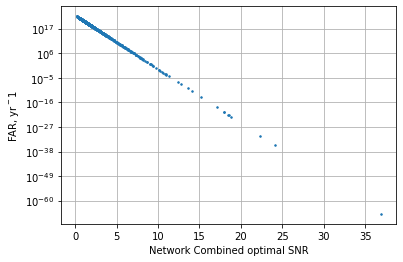

In [8]:
import matplotlib.pyplot as plt
plt.semilogy(samples['net_snr'], samples['FAR'], '.', markersize=3)
plt.ylabel('FAR, yr$^-1$')
plt.xlabel('Network Combined optimal SNR')
plt.grid()

Up to here I've been using the combined SNR as my ranking statistic, this doesn't seem to quite be what is being used in the Nitz paper.

Nitz uses the quadrature sum of the **reweighted SNR, $\hat{\rho}$**:

$\hat{\rho} = \frac{\rho}{[1+(\chi^2)^3]^{1/6}}$

So I need to look at the chi_2 statistic:

* check PyCBC documentation
* check bilby documentation


### Look at the data release SNRs and FARs

In [9]:
#!wget -O ../data_release.csv https://www.gw-openscience.org/eventapi/csv/GWTC/ -P ..

data_release = pd.read_csv('../data_release.csv', index_col=0)
data_release.tail()

,commonName,version,catalog.shortName,GPS,reference,jsonurl,mass_1_source,mass_1_source_lower,mass_1_source_upper,mass_2_source,...,redshift_upper,far,far_lower,far_upper,p_astro,p_astro_lower,p_astro_upper,final_mass_source,final_mass_source_lower,final_mass_source_upper
id,,,,,,,,,,,,,,,,,,,,,
GW200306_093714-v1,GW200306_093714,1,GWTC-3-confident,1.267523e+09,/GWTC-3/,https://www.gw-openscience.org/eventapi/json/G...,28.3,-7.7,17.1,14.8,...,0.24,24.00000,NaN,NaN,0.240040,NaN,NaN,41.7,-6.9,12.3
GW200308_173609-v1,GW200308_173609,1,GWTC-3-confident,1.267724e+09,/GWTC-3/,https://www.gw-openscience.org/eventapi/json/G...,36.4,-9.6,11.2,13.8,...,0.32,2.40000,NaN,NaN,0.856600,NaN,NaN,47.4,-7.7,11.1
GW200311_115853-v1,GW200311_115853,1,GWTC-3-confident,1.267963e+09,/GWTC-3/,https://www.gw-openscience.org/eventapi/json/G...,34.2,-3.8,6.4,27.7,...,0.05,0.00001,NaN,NaN,0.990000,NaN,NaN,59.0,-3.9,4.8
GW200316_215756-v1,GW200316_215756,1,GWTC-3-confident,1.268431e+09,/GWTC-3/,https://www.gw-openscience.org/eventapi/json/G...,13.1,-2.9,10.2,7.8,...,0.08,0.00001,NaN,NaN,0.990000,NaN,NaN,20.2,-1.9,7.4
GW200322_091133-v1,GW200322_091133,1,GWTC-3-confident,1.268904e+09,/GWTC-3/,https://www.gw-openscience.org/eventapi/json/G...,34.0,-18.0,48.0,14.0,...,0.84,140.00000,NaN,NaN,0.077572,NaN,NaN,53.0,-26.0,38.0


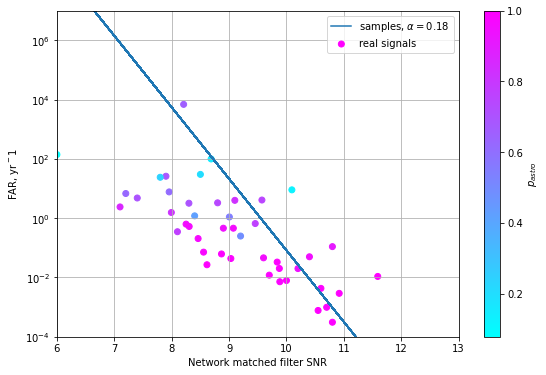

In [10]:
fig, ax = plt.subplots(figsize = (9, 6))
sc = ax.scatter(x=data_release['network_matched_filter_snr'], y=(data_release['far']), c=data_release['p_astro'], cmap='cool', label='real signals')
ax.set_yscale("log")
plt.ylabel('FAR, yr$^-1$')
plt.xlabel('Network matched filter SNR')
plt.semilogy(samples['net_snr'], samples['FAR'], '-', markersize=3, label=r'samples, $\alpha = 0.18$')
plt.grid()
plt.xlim((6,13))
plt.ylim((1e-4,1e7))
fig.colorbar(sc, label='$p_{astro}$')
plt.legend()

Text(0.5, 1.0, 'Cumulative Histogram of SNRs')

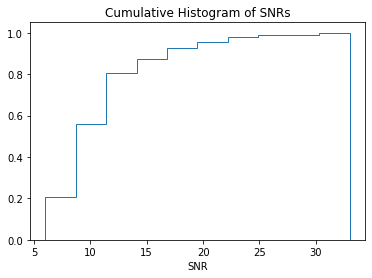

In [11]:
plt.hist(data_release['network_matched_filter_snr'], density=True, histtype='step', cumulative=True)
plt.xlabel('SNR')
plt.title('Cumulative Histogram of SNRs')

<AxesSubplot:ylabel='Density'>

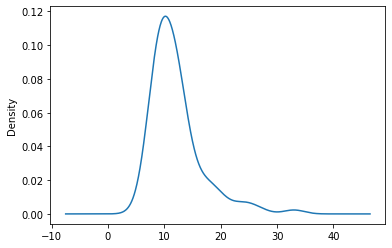

In [12]:
data_release['network_matched_filter_snr'].plot.kde()

### Next steps
* download the full catalogs, the events **do not** need to be actual signals, we are just interested in the relationship between FAR and SNR here
* confirm the form of the detection statistic $\rho$
    * Maggiore, $\chi^2$
* fit the FAR, $\rho$ relationship for a better $\alpha$
    * this will involve removing those which have saturated

In [13]:
#!wget -O ../gwtc3_candidates https://zenodo.org/record/5546665/files/search_data.tar.gz?download=1 -P ..

# !tar -xvzf ../gwtc3_candidates -C ../GWTC3_search_prods

pathToData = '/data/wiay/johnny/phd1/GWTC3_search_prods/search_data_products/pycbc_highmass/'
full_list = os.listdir(pathToData)
# import xml.etree.ElementTree
len(full_list)

329

In [14]:
snr=[]
far=[]
combined_far=[]
jul_yr = 31557600

for file in full_list:
    try:
        # read from the xml the last object in the coinc_inspiral:table which is the snr
        snr.append(float(pd.read_xml(pathToData+file)['Stream'][6].split(",")[-1]))
        # we also want the combined_far[1] and the false_alarm_rate[4]
        far.append(float(pd.read_xml(pathToData+file)['Stream'][6].split(",")[4]))
        combined_far.append(float(pd.read_xml(pathToData+file)['Stream'][6].split(",")[1])*jul_yr)
    except:
        print(file)


skymaps_ligolw
skymaps
o3a_pastro
pastro


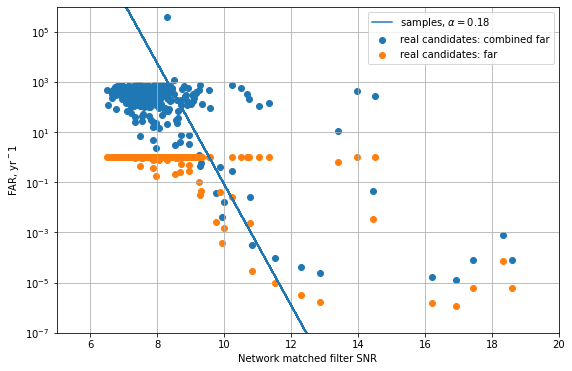

In [15]:
fig, ax = plt.subplots(figsize = (9, 6))
sc = ax.scatter(x=snr, y=combined_far, label='real candidates: combined far')
ax.set_yscale("log")
plt.ylabel('FAR, yr$^-1$')
plt.xlabel('Network matched filter SNR')
plt.semilogy(samples['net_snr'], samples['FAR'], '-', markersize=3, label=r'samples, $\alpha = 0.18$')
plt.scatter(snr, far, label='real candidates: far')
plt.xlim((5,20))
plt.ylim((1e-7,1e6))
# fig.colorbar(sc, label='$p_{astro}$')
plt.legend()
plt.grid()

In [16]:
# !wget -O ../search_data_GWTC2p1.tar.gz https://zenodo.org/record/5759108/files/search_data_GWTC2p1.tar.gz?download=1 -P ..

# !tar -xvzf ../search_data_GWTC2p1.tar.gz -C ../GWTC2p1_search_prods

pathToData = '/data/wiay/johnny/phd1//GWTC2p1_search_prods/search_data_products/pycbc_highmass/'
full_list = os.listdir(pathToData)
len(full_list)

332

In [17]:
snr_21=[]
far_21=[]
combined_far_21=[]
jul_yr = 31557600

for file in full_list:
    try:
        # read from the xml the last object in the coinc_inspiral:table which is the snr
        snr_21.append(float(pd.read_xml(pathToData+file)['Stream'][6].split(",")[-1]))
        # we also want the combined_far[1] and the false_alarm_rate[4]
        far_21.append(float(pd.read_xml(pathToData+file)['Stream'][6].split(",")[4]))
        combined_far_21.append(float(pd.read_xml(pathToData+file)['Stream'][6].split(",")[1])*jul_yr)
    except:
        print(file)

skymaps_ligolw
skymaps
pastro


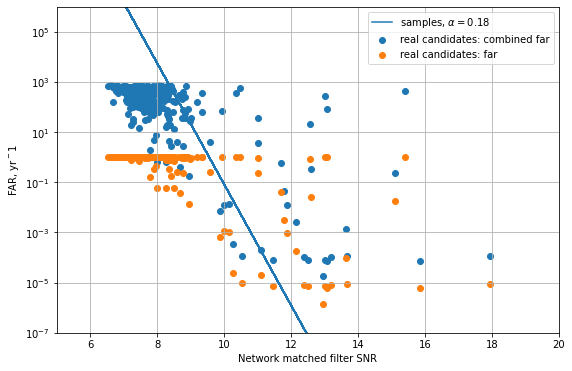

In [18]:
fig, ax = plt.subplots(figsize = (9, 6))
sc = ax.scatter(x=snr_21, y=combined_far_21, label='real candidates: combined far')
ax.set_yscale("log")
plt.ylabel('FAR, yr$^-1$')
plt.xlabel('Network matched filter SNR')
plt.semilogy(samples['net_snr'], samples['FAR'], '-', markersize=3, label=r'samples, $\alpha = 0.18$')
plt.scatter(snr_21, far_21, label='real candidates: far')
plt.xlim((5,20))
plt.ylim((1e-7,1e6))
# fig.colorbar(sc, label='$p_{astro}$')
plt.legend()
plt.grid()

Now I need to:
* combine the two datasets
* remove duplicates as it says the GWTC3 set contain a subset of GWTC2.1
* remove those which have saturated

In [19]:
# combine the lists into a dataframe
snr_all = snr + snr_21
far_all = far + far_21
combined_far_all = combined_far + combined_far_21
data_release_snr_far = pd.DataFrame(list(zip(snr_all, far_all, combined_far_all)), columns=['snr', 'far', 'combined_far'])
print(len(data_release_snr_far))

# drop duplicates from this dataframe
data_release_snr_far_drop = data_release_snr_far.drop_duplicates()
print(len(data_release_snr_far_drop))
# drop saturated far values from this dataframe
data_release_snr_far_drop_sat = data_release_snr_far_drop.drop_duplicates(subset=['combined_far'], keep='first')
print(len(data_release_snr_far_drop_sat))
# drop rows close to far = 1
data_release_snr_far_drop_sat = data_release_snr_far_drop_sat[data_release_snr_far_drop_sat.far < 0.99]
print(len(data_release_snr_far_drop_sat))

654
654
647
101


In [20]:
# later we use the combined far and drop out the far so I want to recreat this FAR > 0.99 cut in terms of combined far
combined_far_cut = data_release_snr_far_drop_sat['combined_far'].max()

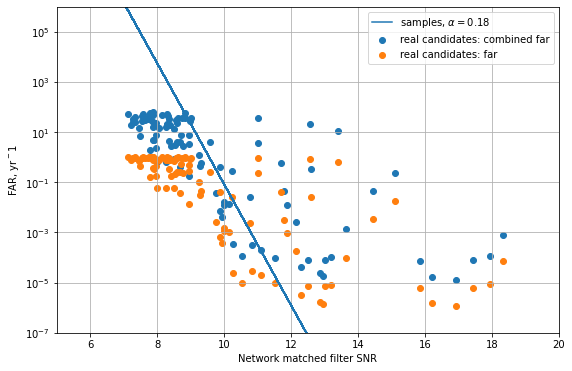

In [21]:
fig, ax = plt.subplots(figsize = (9, 6))
sc = ax.scatter(x=data_release_snr_far_drop_sat['snr'], y=data_release_snr_far_drop_sat['combined_far'], label='real candidates: combined far')
ax.set_yscale("log")
plt.ylabel('FAR, yr$^-1$')
plt.xlabel('Network matched filter SNR')
plt.semilogy(samples['net_snr'], samples['FAR'], '-', markersize=3, label=r'samples, $\alpha = 0.18$')
plt.scatter(x=data_release_snr_far_drop_sat['snr'], y=data_release_snr_far_drop_sat['far'], label='real candidates: far')
plt.xlim((5,20))
plt.ylim((1e-7,1e6))
# fig.colorbar(sc, label='$p_{astro}$')
plt.legend()
plt.grid()
plt.savefig('snr_far_relationship.png')

In [22]:
# we want to fit the snr_to_far relationship to the data and see if a different alpha (or FAR8) comes out
from scipy.optimize import curve_fit

def far_fn_both(snr, FAR8, alpha):
    """Calculate the FAR using the parameterisations from the Lynch paper"""
    FAR = FAR8*np.exp(-(snr-8)/alpha)
    return FAR

parameters, covariance = curve_fit(far_fn_both, data_release_snr_far_drop_sat['snr'], data_release_snr_far_drop_sat['combined_far'])

fit_FAR8_both = parameters[0]
fit_alpha_both = parameters[1]
print(fit_FAR8_both, fit_alpha_both)

fitted_FAR_alpha_FAR8 = far_fn_both(data_release_snr_far_drop_sat['snr'], fit_FAR8_both, fit_alpha_both)

22.765344123073156 1.7292183560461112


In [23]:
def far_fn(snr, alpha):
    """Calculate the FAR using the parameterisations from the Lynch paper"""
    FAR = 5500*np.exp(-(snr-8)/alpha)
    return FAR

parameters, covariance = curve_fit(far_fn, data_release_snr_far_drop_sat['snr'], data_release_snr_far_drop_sat['combined_far'])

fit_alpha = parameters[0]
print(fit_alpha)

fitted_FAR_alpha = far_fn(data_release_snr_far_drop_sat['snr'], fit_alpha)

2.113663230696922


In [24]:
jul_yr = 31557600

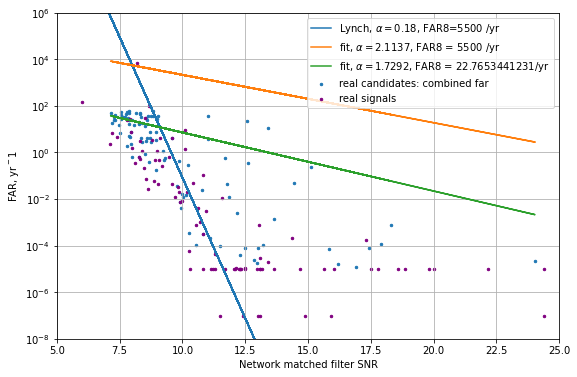

In [25]:
fig, ax = plt.subplots(figsize = (9, 6))
sc = ax.scatter(x=data_release_snr_far_drop_sat['snr'], y=data_release_snr_far_drop_sat['combined_far'], label='real candidates: combined far', s=6)
ax.set_yscale("log")
plt.ylabel('FAR, yr$^-1$')
plt.xlabel('Network matched filter SNR')
plt.semilogy(samples['net_snr'], samples['FAR'], '-', markersize=3, label=r'Lynch, $\alpha = 0.18$, FAR8=5500 /yr')
plt.semilogy(data_release_snr_far_drop_sat['snr'], fitted_FAR_alpha, '-', markersize=3, label=r'fit, $\alpha = {}$, FAR8 = 5500 /yr'.format(np.round(fit_alpha, 4)))
plt.semilogy(data_release_snr_far_drop_sat['snr'], fitted_FAR_alpha_FAR8, '-', markersize=3, label=r'fit, $\alpha = {}$, FAR8 = {}/yr'.format(np.round(fit_alpha_both,4), np.round(fit_FAR8_both, 10)))
#plt.scatter(x=data_release_snr_far_round_drop_sat['snr'], y=data_release_snr_far_round_drop_sat['far'], label='real candidates: false_alarm_rate', s=6)
plt.scatter(x=data_release['network_matched_filter_snr'], y=(data_release['far']), label='real signals', s=6, c='purple')
plt.xlim((5,25))
plt.ylim((1e-8,1e6))
# fig.colorbar(sc, label='$p_{astro}$')
plt.legend()
plt.grid()
plt.savefig('snr_far_relationship.png')

Text(0.5, 0, 'FAR')

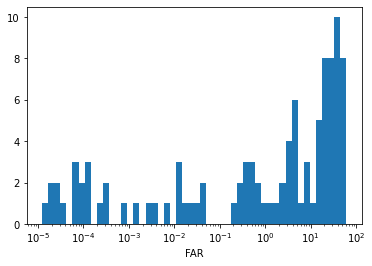

In [26]:
def plot_loghist(x, bins):
  hist, bins = np.histogram(x, bins=bins)
  logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
  plt.hist(x, bins=logbins)
  plt.xscale('log')
plot_loghist(data_release_snr_far_drop_sat['combined_far'], 50)
plt.xlabel('FAR')

Some notes:
* the above fits are to the combined far not to the far
* the FAR8 = 5500 looks like it's way off this dataset
* my FAR cut to remove the saturated values also doesn't look strong enough, the fit is heavily skewed towards these
* the SNRs from my samples are a combined SNR for HLV whereas the FAR and SNR from the true data are a mixture of combinations of HLV and single detectors
    * **what is the relationship between FAR and combined FAR?**
        *  it mostly looks like it's a shift from the plots but I would expect single detector candidates to have the same FAR and combined_FAR
* what is the pyCBC broad SNR caluclation

from GWTC3:

"PyCBC Live uses a more computationally simple ranking statistic than the one used in offline analyses. This simpler ranking statistic is used in order to maintain speed in a low latency en-vironment and does not contain all of the information used in the offline statistic. The reduced χ2-reweighted SNR [21] and a sine–Gaussian veto [386, 606] are used
to assess significance of single-detector triggers. These
single-detector triggers are then tested for coincidence,
and the coincident ranking statistic is calculated. The
ranking statistic is compared to the time-shifted back-
ground from five hours of data to estimate FAR."

from https://pycbc.org/pycbc/latest/html/formats/hdf_format.html?highlight=combined
* looks like it describs the sngl_inspiral section of the xml files
* I have checked these SNRs against the coinc_inspiral which is just the quadratic sum
    * these snrs are the mangitude of the complex SNR
* "we keep its coincidence if its ranking statistic (newSNR) > 8.5"
    * these files have SNR<8.5 suggesting it's not newSNR

far = [lal.YRJUL_SI * coinc_results['foreground/ifar']]$^{-1}$ = combined_far, where lal.YRJUL_SI is the julian year

false_alarm_rate = 0

It looks like these files are built from https://pycbc.org/pycbc/latest/html/_modules/pycbc/io/live.html, and more info at https://pycbc.org/pycbc/latest/html/_modules/pycbc/io/hdf.html 
* it looks like far is actually the fap, false alarm probability, which makes sense as the values have a maximum of 1
* which means I want combined_far whis is 1/ifar

false_alarm_rate = coinc_event_vals['fap']

combined_far = [coinc_event_vals['ifar']]$^{-1}$


Let's do the fit again but with the real signals and the candidates combined

747
747
703
85
1.01537516980206 0.9477480993104601
0.43076168242541274


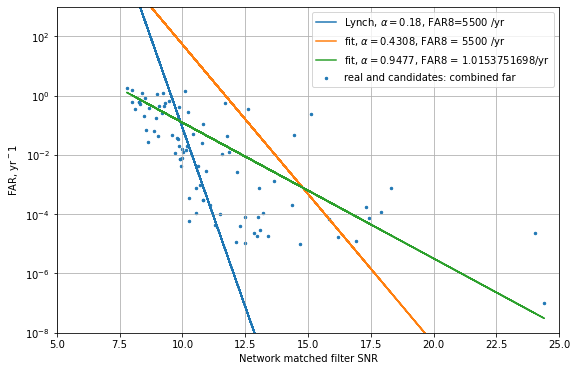

In [27]:
# trimming
# get the real signals as a list
real_snr = data_release['network_matched_filter_snr'].tolist()
real_far = data_release['far'].tolist()
# combine the lists into a dataframe
snr_all_real = snr + snr_21 + real_snr
combined_far_all_real = combined_far + combined_far_21 + real_far
data_release_snr_far_real = pd.DataFrame(list(zip(snr_all_real, combined_far_all_real)), columns=['snr', 'combined_far'])
print(len(data_release_snr_far_real))

# drop duplicates from this dataframe
real_data_release_snr_far_drop = data_release_snr_far_real.drop_duplicates()
print(len(real_data_release_snr_far_drop))
# drop saturated far values from this dataframe
real_data_release_snr_far_drop_sat = real_data_release_snr_far_drop.drop_duplicates(subset=['combined_far'], keep='first')
print(len(real_data_release_snr_far_drop_sat))
# drop rows close to far = 1
real_data_release_snr_far_drop_sat = real_data_release_snr_far_drop_sat[real_data_release_snr_far_drop_sat.combined_far < 2]
print(len(real_data_release_snr_far_drop_sat))


# fitting
# fitting the function with both free parameters
parameters, covariance = curve_fit(far_fn_both, real_data_release_snr_far_drop_sat['snr'], real_data_release_snr_far_drop_sat['combined_far'])

fit_FAR8_both = parameters[0]
fit_alpha_both = parameters[1]
print(fit_FAR8_both, fit_alpha_both)
# feed the function the snr's and the fitted parameters
fitted_FAR_alpha_FAR8 = far_fn_both(real_data_release_snr_far_drop_sat['snr'], fit_FAR8_both, fit_alpha_both)

# the function with just one free parameter
parameters1, covariance1 = curve_fit(far_fn, real_data_release_snr_far_drop_sat['snr'], real_data_release_snr_far_drop_sat['combined_far'])

fit_alpha = parameters1[0]
print(fit_alpha)

fitted_FAR_alpha = far_fn(real_data_release_snr_far_drop_sat['snr'], fit_alpha)


# plotting
fig, ax = plt.subplots(figsize = (9, 6))
sc = ax.scatter(x=real_data_release_snr_far_drop_sat['snr'], y=real_data_release_snr_far_drop_sat['combined_far'], label='real and candidates: combined far', s=6)
ax.set_yscale("log")
plt.ylabel('FAR, yr$^-1$')
plt.xlabel('Network matched filter SNR')
plt.semilogy(samples['net_snr'], samples['FAR'], '-', markersize=3, label=r'Lynch, $\alpha = 0.18$, FAR8=5500 /yr')
plt.semilogy(real_data_release_snr_far_drop_sat['snr'], fitted_FAR_alpha, '-', markersize=3, label=r'fit, $\alpha = {}$, FAR8 = 5500 /yr'.format(np.round(fit_alpha, 4)))
plt.semilogy(real_data_release_snr_far_drop_sat['snr'], fitted_FAR_alpha_FAR8, '-', markersize=3, label=r'fit, $\alpha = {}$, FAR8 = {}/yr'.format(np.round(fit_alpha_both,4), np.round(fit_FAR8_both, 10)))

plt.xlim((5,25))
plt.ylim((1e-8,1e3))
# fig.colorbar(sc, label='$p_{astro}$')
plt.legend()
plt.grid()
plt.savefig('snr_far_relationship_real_and_candidates.png')

### Using the parameterisation
I can proceed with this parameterisation for now and can always come back and update.
So let's now convert SNRs into FARs.

The above fit gives FAR8 to be 1.015, let's call this 1. $\alpha = 0.9477$ lets call this 0.95.

**have I introduced some sort of bias by cutting my FARs?**

In [28]:
# my snr to far function
def far_fn(snr, FAR8=1, alpha=0.95):
    """Calculate the FAR using the parameterisations from the Lynch paper"""
    FAR = FAR8*np.exp(-(snr-8)/alpha)
    return FAR

In [30]:
samples['FAR'] = far_fn(samples['net_snr'])
samples.to_csv('params_inc_FAR.csv')

In [31]:
samples.head()

,mass_1,mass_ratio,a_1,a_2,cos_tilt_1,cos_tilt_2,redshift,mass_2,chi_eff,tilt_1,...,V1_snr,theta_jn,psi,phase,ra,dec,phi_12,phi_jl,net_snr,FAR
0,14.206189,0.753297,0.084464,0.150304,-0.261760,0.392646,0.906271,10.701485,0.012746,1.835642,...,1.249735,0.478923,2.518351,4.208321,3.068214,0.029949,1.709171,6.212235,4.715177,31.744143
1,7.631592,0.987168,0.301969,0.514466,-0.610410,-0.613718,1.837756,7.533664,-0.249606,2.227374,...,0.376991,2.060811,2.176761,3.695127,3.062258,0.902357,5.343215,3.462008,0.762437,2035.480706
2,6.088737,0.993740,0.235612,0.437827,0.873063,0.821194,2.090188,6.050621,0.282381,0.509347,...,0.782588,2.746061,0.839684,2.333354,5.323210,1.533282,3.987185,4.133948,1.630003,816.690300
3,13.368498,0.656860,0.519649,0.126563,0.212090,-0.385168,1.802572,8.781230,0.047193,1.357083,...,0.249479,1.376382,2.458206,0.808485,3.241303,0.622675,1.394951,0.676842,0.953321,1664.960105
4,23.997822,0.479771,0.313633,0.007355,0.270814,0.404514,1.759925,11.513460,0.058363,1.296558,...,0.578285,1.917434,0.655696,5.435143,1.227290,1.416742,0.354682,3.028431,1.492217,944.162258
